In [20]:
include("../src/network_transmission_workplace.jl")

LoadError: LoadError: [91msyntax: missing comma or ) in argument list[39m
in expression starting at /Users/carlwhitfield/Documents/Github/Workplace_delivery_transmission/Network_workplace_model/src/network_transmission_workplace.jl:487

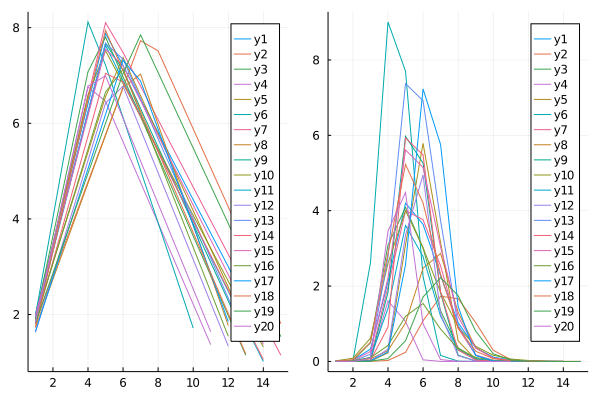

In [2]:
Ntest = 20
simtest = init_VL_and_infectiousness(Ntest,0.0)
plot1 = Plots.plot(simtest["VL_profiles"][1])
for n in 2:Ntest
    plot1 = Plots.plot!(simtest["VL_profiles"][n])
end
plot2 = Plots.plot(simtest["infection_profiles"][1])
for n in 2:Ntest
    plot2 = Plots.plot!(simtest["infection_profiles"][n])
end
Plots.plot(plot1,plot2)

In [12]:
RandomAbsenceRate = 0.03
BulkOccPattern = [0.82, 0.98, 0.97, 0.99, 1.0, 0.84, 0.47]
BulkPkgPattern = [0.80, 0.94, 0.95, 0.94,  1.0, 0.81, 0.44]
NPbulk = 210
NDbulk_def = Int64(ceil(mean(NPbulk*BulkPkgPattern ./ 
                             (15.0*(1.0-RandomAbsenceRate)*BulkOccPattern))))
NLbulk_def = Int64(ceil(0.8*NDbulk_def))
NObulk_def = Int64(ceil(0.4*NDbulk_def))
NStaffbulk_def = NDbulk_def + NLbulk_def + NObulk_def
Params = Dict("ND"=>NDbulk_def, "NL"=>NLbulk_def, "NO"=>NObulk_def, 
               "NDteams"=>2, "NLteams"=>2, "NOteams"=>1,
               "is_cohorts"=>true, "Pisol"=>0.9, "Psusc"=>1.0, 
               "p_contact"=>(2.0/(NStaffbulk_def)),
               "tD"=>0.1, "phi"=>1.0, "InfInit"=>0, "SimType"=>Outbreak_sim,
               "TeamTimes"=>[0.25,1.0,1.0], "TeamsOutside"=>[false,false,false],
               "TeamDistances"=>[1.0,1.0,1.0], "HouseShareFactor"=>0.1,
               "CarShareFactor"=>0.05, "BreakContactProb"=>0.25, 
               "CohortChangeRate"=>(1.0/(NStaffbulk_def)),
               "AbsenceRate"=>RandomAbsenceRate, "CustomerOutdoorFrac"=>0.5)
PairParams = Dict("is_driver_pairs"=>true, "is_loader_pairs"=>true,
                  "fixed_driver_pairs"=>true, "fixed_loader_pairs"=>true,
                  "is_window_open"=>false, "PairIsolation"=>true)
TestParams = Dict("is_testing"=>true, "test_miss_prob"=>0.4, "testing_enforced"=>false,
             "tperiod"=>4, "protocol"=>LFD_mass_protocol,
             "specificity"=>0.999, "delay"=>0.0,
             "test_pause"=>21.0)
NWeeks = 20
OCCPD =repeat(BulkOccPattern,NWeeks)
NP = Int64.(round.(NPbulk * OCCPD)) 
incidence = 0.002 *(1 .- (1 .- 2*collect(0:NWeeks*7-1)./(NWeeks*7)).^2)
prevalence = cumsum(incidence) - cumsum(vcat(zeros(7),incidence[1:(end-7)]))

results=Dict()
go = true
while go || sum(results["Recovered"],dims=1)[end] < 10
    results = run_sim_delivery_wp(Params, OCCPD, NP; PairParams=PairParams, TestParams=TestParams)
    go = false
end

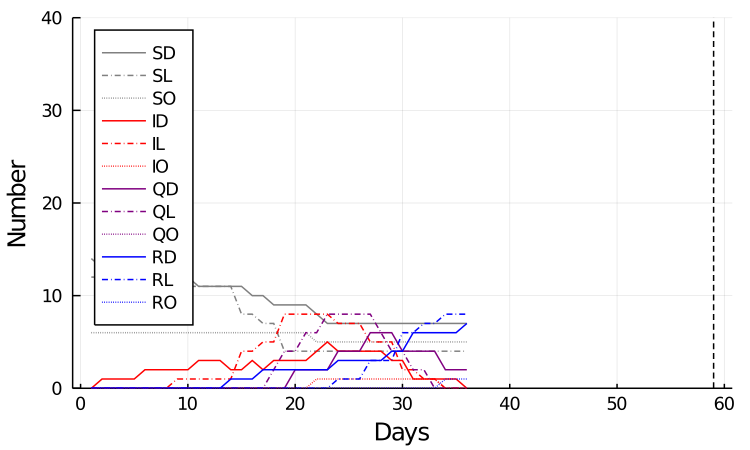

In [20]:
Plots.plot([59,59],[0,40],color=:black,style=:dash,label=:none)
Plots.plot!(results["time"],transpose(results["Susceptible"]),label=["SD" "SL" "SO"], 
    style=[:solid :dashdot :dot], color=:grey)
Plots.plot!(results["time"],transpose(results["Infectious"]),label=["ID" "IL" "IO"], 
    style=[:solid :dashdot :dot], color=:red)
Plots.plot!(results["time"],transpose(results["Isolated"]),label=["QD" "QL" "QO"], 
    style=[:solid :dashdot :dot], color=:purple)
# Plots.plot(results["time"],transpose(cumsum(sum(results["ExternalIntroductions"],dims=1),dims=2)),label="ExtIntros")
# Plots.plot!(results["time"],transposecumsum(sum(results["CustomerIntroductions"],dims=1),dims=2)),label="CustIntros")
#Plots.plot!(results["time"],transpose(cumsum(sum(results["FomiteInfs"],dims=1),dims=2)),label="Pkg")
# Plots.plot!(results["time"],transpose(cumsum(sum(results["PairInfs"],dims=1),dims=2)),label="Pair")
Plots.plot!(results["time"],transpose(results["Recovered"]),label=["RD" "RL" "RO"], 
    style=[:solid :dashdot :dot], color=:blue, legend=:topleft,ylim=(0,40),xlabel="Days",
    ylabel="Number",size=(500,300),dpi=150)

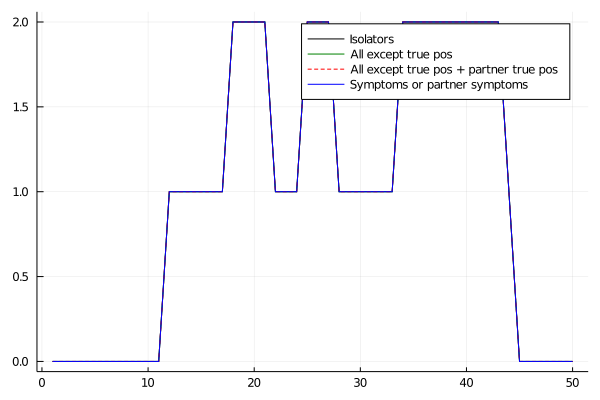

In [7]:
#Plots.plot(results["time"],transpose(sum(results["Infectious"],dims=1)),label="Infectious")
IS = results["Isolated"] 
IST1 = results["IsolatedDueToTestSymp"] + results["IsolatedDueToTestAsymp"]
IST2 = results["IsolatedDueToPartnerTruePos"]
ISF1 = results["IsolatedDueToFalsePos"]
ISF2 = results["IsolatedDueToPartnerFalsePos"]
ISS = IS - IST1 - IST2 - ISF1 - ISF2
Plots.plot(results["time"],transpose(sum(IS,dims=1)),label="Isolators", c = :black)
Plots.plot!(results["time"],transpose(sum(IS - IST1,dims=1)),label="All except true pos", c = :green)
Plots.plot!(results["time"],transpose(sum(IS - IST1 - IST2,dims=1)),label="All except true pos + partner true pos", c = :red, s=:dash)
Plots.plot!(results["time"],transpose(sum(IS - IST1 - IST2 - ISF1 - ISF2,dims=1)),label="Symptoms or partner symptoms", c = :blue)



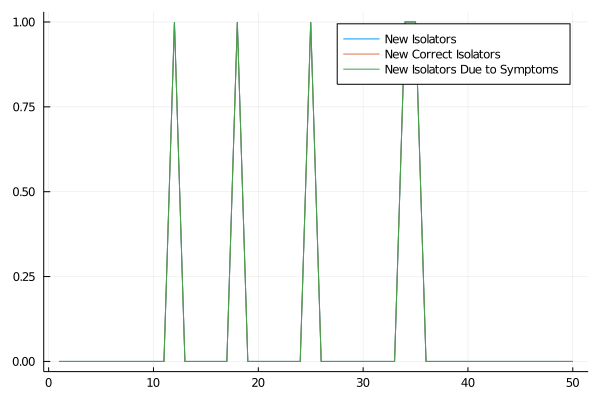

In [8]:
#Plots.plot(results["time"],transpose(sum(results["Infectious"],dims=1)),label="Infectious")
IS = results["NewIsolators"] 
Plots.plot(results["time"],transpose(sum(IS,dims=1)),label="New Isolators")
IS1 = IS .- results["NewFalseIsolators"]
Plots.plot!(results["time"],transpose(sum(IS1,dims=1)),label="New Correct Isolators")
IS2 = IS1 .- results["NewTestSympIsolators"] .- results["NewTestAsympIsolators"]
Plots.plot!(results["time"],transpose(sum(IS2,dims=1)),label="New Isolators Due to Symptoms")
#Plots.plot!(results["time"],transpose(sum(results["IsolatedDueToFalsePos"],dims=1)),label="Test Isolation FalsePos")
#Plots.plot!(results["time"],100*results["Incidence"])

In [520]:
print(sum(results["NewIsolators"] .- results["NewFalseIsolators"])/sum(results["Recovered"],dims=1)[end])

0.6060606060606061

In [17]:
Plots.plot(results["time"], results["CustomersInfectedByDrivers"])
#Plots.plot!(results["time"], results["PackagesInfectiousOnDelivery"])
Plots.plot!(results["time"], results["CustomersInfectedByPkgs"])
print(sum(results["CustomersInfectedByDrivers"]), ' ', sum(results["CustomersInfectedByPkgs"]))

7 4

In [69]:
n = sum(results["NetworkInfs"],dims=2)
c = sum(results["ContactInfs"],dims=2)
r = sum(results["RoomInfs"],dims=2)
e = sum(results["ExternalIntroductions"],dims=2)
ci = sum(results["CustomerIntroductions"],dims=2)
p = sum(results["PairInfs"],dims=2)
print(n+p)
print(results["Recovered"][:,end])

[14; 0; 1][24, 3, 4]

In [ ]:
#sc edits

In [3]:
rel_demand = [0.94905289, 1.12035227, 1.13224753, 1.11989019, 1.18869848, 0.96182216, 0.52793647]
print(rel_demand/max(rel_demand...))

[0.7983966548018132, 0.9425033251493683, 0.9525102867129096, 0.9421145974713453, 1.0, 0.809138882721546, 0.444129843591623]

In [27]:
results

Dict{Any,Any} with 33 entries:
  "Isolated"                     => [0 0 … 2 2; 0 0 … 0 0; 0 0 … 0 0]
  "NewTestSympIsolators"         => [0 0 … 0 0; 0 0 … 0 0; 0 0 … 0 0]
  "NewPartnerTruePosIsolators"   => [0 0 … 0 0; 0 0 … 0 0; 0 0 … 0 0]
  "IsolatedDueToPartnerTruePos"  => [0 0 … 1 1; 0 0 … 0 0; 0 0 … 0 0]
  "PairInfs"                     => [0 0 … 0 0; 0 0 … 0 0; 0 0 … 0 0]
  "NewIsolators"                 => [0 0 … 0 0; 0 0 … 0 0; 0 0 … 0 0]
  "CustomersInfectedByDrivers"   => [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, …
  "IsolatedDueToFalsePos"        => [0 0 … 0 0; 0 0 … 0 0; 0 0 … 0 0]
  "IsolatedDueToSymptoms"        => [0 0 … 48 48; 0 0 … 30 30; 0 0 … 15 15]
  "Asymptomatic"                 => [0 0 … 3 3; 0 0 … 0 0; 0 0 … 0 0]
  "Susceptible"                  => [50 50 … 27 27; 30 30 … 27 27; 15 15 … 13 1…
  "FomiteInfs"                   => [0 0 … 0 0; 0 0 … 0 0; 0 0 … 0 0]
  "time"                         => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  131, 132…
  "ContactInfs"     

Defined Plot attributes are:
background_color, background_color_outside, display_type, dpi, extra_kwargs, extra_plot_kwargs, fontfamily, foreground_color, html_output_format, inset_subplots, layout, link, overwrite_figure, plot_title, plot_title_location, plot_titlefontcolor, plot_titlefontfamily, plot_titlefonthalign, plot_titlefontrotation, plot_titlefontsize, plot_titlefontvalign, pos, show, size, tex_output_standalone, thickness_scaling, warn_on_unsupported, window_title


89.00549056999311

In [1]:
include("../src/network_transmission_workplace.jl")

run_sim_delivery_wp (generic function with 1 method)

Test cohorting

In [21]:
sim=Dict()
sim["N"] = [10,10,10]
sim["Ntot"] = sum(sim["N"])
Nteams = [2,2,2]
TeamF2FTime = [0.25,1.0,1.0]
outside = [false,false,false]
distance = [1.0,1.0,1.0]
istart = 0
sim["job"] = zeros(Int8, sim["Ntot"])
sim["job_sorted_nodes"] = Array{Array{Int64,1},1}(undef, 3)
for (i,n) in enumerate(sim["N"])
    nrh = (istart+1):(istart + n)
    sim["job"][nrh] .= i   #assign job/role labels
    sim["job_sorted_nodes"][i] = nrh
    istart += n
end
generate_cohort_graph!(sim, Nteams, TeamF2FTime, outside, distance)

2-element Array{Array{Int64,1},1}:
 [22, 23, 26, 27, 30]
 [21, 24, 25, 28, 29]

In [22]:
sim["cohorts"]

3-element Array{Array{Array{Int64,1},1},1}:
 [[3, 4, 6, 7, 8, 9, 19], [1, 2, 5, 10, 14]]
 [[13, 14, 17], [11, 12, 15, 16, 18, 19, 20]]
 [[22, 23, 26, 27, 30], [21, 24, 25, 28, 29]]

In [24]:
find_cohort_no_and_members(sim, Int8(2), 19)

(2, [11, 12, 15, 16, 18, 20])

In [53]:
shuffle_cohorts!(sim, 0.1, Nteams, TeamF2FTime, outside, distance)

In [77]:
shuffle_cohorts!(sim, 0.1, Nteams, TeamF2FTime, outside, distance)
sim["cohorts"]

3-element Array{Array{Array{Int64,1},1},1}:
 [[19, 7, 6, 2, 5, 10], [14, 9, 8, 3, 4, 1]]
 [[15, 17, 13], [11, 16, 18, 14, 12, 19, 20]]
 [[21, 23, 28, 30, 26], [24, 29, 22, 25, 27]]

In [78]:
HomeParams = Dict("HouseShareFactor"=>0.1,"CarShareFactor"=>0.05)
generate_car_share_and_house_share_graphs!(sim, HomeParams)

([[17], [27], [10], [12], [16], [3], [20], [24], [26], [4]  …  [11], [25], [13], [22], [29, 2], [23], [6], [15], [18], [14]], [[28], [7], [16], [6], [25], [20], [15, 12], [4], [18], [27]  …  [23], [10], [5], [1], [24], [19], [11], [30], [26], [21]])

In [175]:
sim["infection_status"] = zeros(Int64,sim["Ntot"])
sim["infection_status"][8] = Expd
sim["infection_status"][14] = Expd
sim["susceptibility"] = ones(Float64,sim["Ntot"])
sim["susceptibility"][8] = 0.0
sim["susceptibility"][14] = 0.0
sim["at_work"] = ones(Bool,sim["Ntot"])
comp_net = collate_networks(sim)
update_contact_network!(sim, comp_net)

inf = [8,14]
inf_scales = [0.5,2.0]
nbrs = neighbors.(Ref(sim["contact_network"]), inf)
nin = vcat(fill.(inf,length.(nbrs))...)
nout = vcat(nbrs...)
j_inf = vcat(fill.(inf_scales,length.(nbrs))...)
j_susc = sim["susceptibility"][nout]
w = get_prop.(Ref(sim["contact_network"]),nin,nout,:weights)
t = get_prop.(Ref(sim["contact_network"]),nin,nout,:types)
nin_all = vcat(fill.(nin,length.(w))...)
nout_all = vcat(fill.(nout,length.(w))...)
j_inf_all = vcat(fill.(j_inf,length.(w))...)
j_susc_all = vcat(fill.(j_susc,length.(w))...)
beta = vcat(w...)
etype = vcat(t...)
eprob = convert_weight_to_prob.(beta, j_inf_all, j_susc_all)
print(w,'\n',t,'\n')
print(nin_all,'\n', nout_all,'\n', eprob, '\n', etype, '\n')
eind = collect(1:length(eprob))
rnum = rand(length(eprob))
einf = eind[rnum .< 1000*(eprob)]
ipairs = Array{Int64,2}(undef,3,0)
if length(einf) > 0
    ipairs = hcat(ipairs, [transpose(nin_all[einf]);
            transpose(nout_all[einf]); transpose(etype[einf])])
end 
print(eind, '\n', rnum, '\n', einf,'\n',ipairs)

[[0.0035000000000000005], [0.0035000000000000005], [0.0035000000000000005], [0.0035000000000000005, 0.07, 0.007000000000000001], [0.0035000000000000005, 0.0035000000000000005], [0.0035000000000000005], [0.0035000000000000005], [0.0035000000000000005], [0.0035000000000000005, 0.0035000000000000005], [0.0035000000000000005], [0.011666666666666667], [0.011666666666666667], [0.011666666666666667], [0.011666666666666667], [0.011666666666666667], [0.011666666666666667]]
[[1], [1], [1], [1, 9, 8], [1, 1], [1], [1], [1], [1, 1], [1], [1], [1], [1], [1], [1], [1]]
[8, 8, 8, 8, 8, 8, 8, 8, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]
[1, 3, 4, 9, 9, 9, 14, 14, 1, 3, 4, 8, 8, 9, 11, 12, 16, 18, 19, 20]
[0.0017484696428384794, 0.0017484696428384794, 0.0017484696428384794, 0.0017484696428384794, 0.03439458374243354, 0.003493882139585125, 0.0, 0.0, 0.0069755570667648925, 0.0069755570667648925, 0.0069755570667648925, 0.0, 0.0, 0.0069755570667648925, 0.023063216101652406, 0.023063216101652406, 0.02

In [176]:
N = size(ipairs,2)
nkeep = Array{Int64,1}()
ind = randperm(N)
for i in ind
    k = ipairs[2,i]   #node to be infected
    if sim["infection_status"][k] == Susc  #if susceptible
        sim["infection_status"][k] = Expd
        push!(nkeep, i)
    end
end
infpairs_kept = ipairs[:,nkeep]
print(ind,'\n',infpairs_kept,'\n')

[4, 5, 6, 1, 12, 13, 15, 8, 7, 9, 3, 16, 10, 14, 2, 11]
[8 8 14 14 14 14 14 14 14 14; 9 1 12 16 19 3 4 20 18 11; 1 1 1 1 1 1 1 1 1 1]


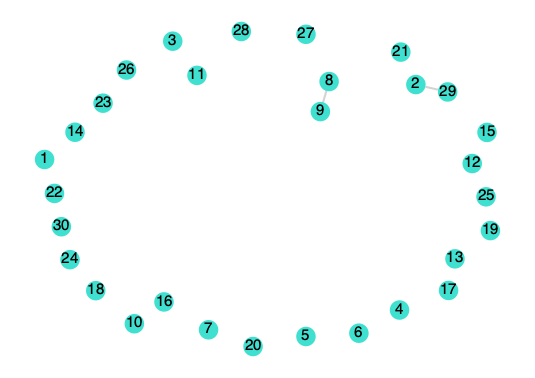

In [159]:
locsx,locsy=spring_layout(sim["house_share_network"],C=5.0)
gplot(sim["house_share_network"], locsx, locsy, nodelabel=1:sim["Ntot"])

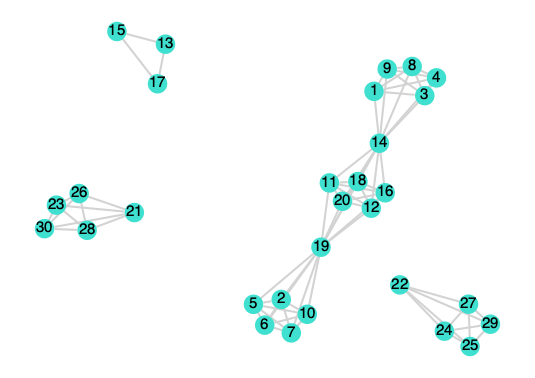

In [156]:
locsx,locsy=spring_layout(sim["cohort_network"],C=5.0)
gplot(sim["cohort_network"], locsx, locsy, nodelabel=1:sim["Ntot"])

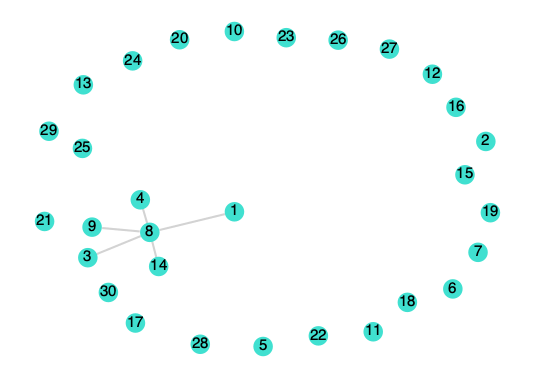

In [3]:
rel_size = 0.5 .+ 1.5.*(0:20)./20

0.5:0.075:2.0

In [8]:
print(-log(0.85)) 

0.16251892949777494

Test fixed pair isolation

In [39]:
include("../src/network_transmission_workplace.jl")

run_sim_delivery_wp (generic function with 1 method)

In [40]:
RandomAbsenceRate = 0.03
BulkOccPattern = [0.82, 0.98, 0.97, 0.99, 1.0, 0.84, 0.47]
BulkPkgPattern = [0.80, 0.94, 0.95, 0.94,  1.0, 0.81, 0.44]
NPbulk = 210
NDbulk_def = Int64(ceil(mean(NPbulk*BulkPkgPattern ./ 
                             (15.0*(1.0-RandomAbsenceRate)*BulkOccPattern))))
NLbulk_def = Int64(ceil(0.8*NDbulk_def))
NObulk_def = Int64(ceil(0.4*NDbulk_def))
NStaffbulk_def = NDbulk_def + NLbulk_def + NObulk_def
Params = Dict("ND"=>NDbulk_def, "NL"=>NLbulk_def, "NO"=>NObulk_def, 
               "NDteams"=>2, "NLteams"=>2, "NOteams"=>1,
               "is_cohorts"=>true, "Pisol"=>0.9, "Psusc"=>1.0, 
               "p_contact"=>(2.0/(NStaffbulk_def)),
               "tD"=>0.1, "phi"=>1.0, "InfInit"=>0, "SimType"=>Outbreak_sim,
               "TeamTimes"=>[0.25,1.0,1.0], "TeamsOutside"=>[false,false,false],
               "TeamDistances"=>[1.0,1.0,1.0], "HouseShareFactor"=>0.1,
               "CarShareFactor"=>0.05, "BreakContactProb"=>0.25, 
               "CohortChangeRate"=>(1.0/(NStaffbulk_def)),
               "AbsenceRate"=>RandomAbsenceRate, "CustomerOutdoorFrac"=>0.5)
PairParams = Dict("is_driver_pairs"=>true, "is_loader_pairs"=>true,
                  "fixed_driver_pairs"=>true, "fixed_loader_pairs"=>true,
                  "is_window_open"=>false, "PairIsolation"=>true)
TestParams = Dict("is_testing"=>true, "test_miss_prob"=>0.4, "testing_enforced"=>false,
             "tperiod"=>4, "protocol"=>LFD_mass_protocol,
             "specificity"=>0.999, "delay"=>0.0,
             "test_pause"=>21.0)
NWeeks = 20
OCCPD =repeat(BulkOccPattern,NWeeks)
NP = Int64.(round.(NPbulk * OCCPD)) 
incidence = 0.002 *(1 .- (1 .- 2*collect(0:NWeeks*7-1)./(NWeeks*7)).^2)
prevalence = cumsum(incidence) - cumsum(vcat(zeros(7),incidence[1:(end-7)]))

resultsFP = run_sim_delivery_wp(Params, OCCPD, NP; PairParams=PairParams, TestParams=TestParams)

Dict{Any,Any} with 28 entries:
  "Isolated"                     => [0 0 … 0 0; 0 0 … 4 4; 0 0 … 0 0]
  "CustomersInfected"            => [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
  "InfsByType"                   => [[0 0 … 0 0; 0 0 … 0 0; 0 0 … 0 0], [0 0 … …
  "IndexCasePeakVL"              => 7.89948
  "IsolatedDueToContactFalsePos" => [0 0 … 0 0; 0 0 … 0 0; 0 0 … 0 0]
  "NewContactTruePosIsolators"   => [0 0 … 0 0; 0 0 … 0 0; 0 0 … 0 0]
  "NewTestSympIsolators"         => [0 0 … 0 0; 0 0 … 0 0; 0 0 … 0 0]
  "NewIsolators"                 => [0 0 … 0 0; 0 0 … 0 0; 0 0 … 0 0]
  "NewContactFalsePosIsolators"  => [0 0 … 0 0; 0 0 … 0 0; 0 0 … 0 0]
  "IsolatedDueToFalsePos"        => [0 0 … 0 0; 0 0 … 0 0; 0 0 … 0 0]
  "IsolatedDueToSymptoms"        => [0 0 … 0 0; 0 0 … 2 2; 0 0 … 0 0]
  "Asymptomatic"                 => [0 0 … 0 0; 0 0 … 2 0; 0 0 … 0 0]
  "Susceptible"                  => [14 14 … 14 14; 11 11 … 8 8; 6 6 … 6 6]
  "time"                         => [1, 2, 3, 4, 5, 6, 7,

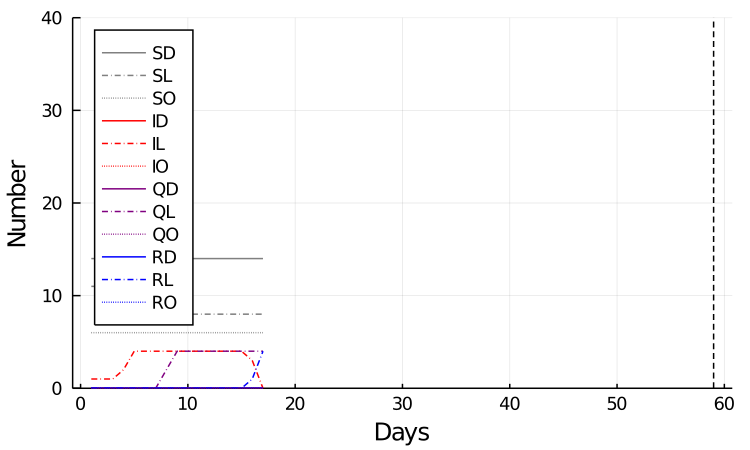

In [41]:
Plots.plot([59,59],[0,40],color=:black,style=:dash,label=:none)
Plots.plot!(resultsFP["time"],transpose(resultsFP["Susceptible"]),label=["SD" "SL" "SO"], 
    style=[:solid :dashdot :dot], color=:grey)
Plots.plot!(resultsFP["time"],transpose(resultsFP["Infectious"]),label=["ID" "IL" "IO"], 
    style=[:solid :dashdot :dot], color=:red)
Plots.plot!(resultsFP["time"],transpose(resultsFP["Isolated"]),label=["QD" "QL" "QO"], 
    style=[:solid :dashdot :dot], color=:purple)
# Plots.plot(results["time"],transpose(cumsum(sum(results["ExternalIntroductions"],dims=1),dims=2)),label="ExtIntros")
# Plots.plot!(results["time"],transposecumsum(sum(results["CustomerIntroductions"],dims=1),dims=2)),label="CustIntros")
#Plots.plot!(results["time"],transpose(cumsum(sum(results["FomiteInfs"],dims=1),dims=2)),label="Pkg")
# Plots.plot!(results["time"],transpose(cumsum(sum(results["PairInfs"],dims=1),dims=2)),label="Pair")
Plots.plot!(resultsFP["time"],transpose(resultsFP["Recovered"]),label=["RD" "RL" "RO"], 
    style=[:solid :dashdot :dot], color=:blue, legend=:topleft,ylim=(0,40),xlabel="Days",
    ylabel="Number",size=(500,300),dpi=150)